# PyTorch CIFAR-10 categorisation project

1. Explore the data
2. Create a baseline to judge results against
2. Implement a neural network
3. Implement improvements
4. Evaluate different parameters

## 1. Explore the data

In [1]:
import torch
from torch import cuda
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

After getting data directly from University of Toront, I realised that PyTorch has it. Oops! Getting using PyTorch below to make code easy to replicate

In [2]:
data_folder = r"../data"

transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor()])
CIFAR_data = CIFAR10(data_folder, train=True, transform=transform, download=True)

train_dataloader = DataLoader(CIFAR_data,
                          batch_size=4,
                          shuffle=True)

CIFAR_test_data = CIFAR10(data_folder, train=False, transform=transform)

test_dataloader = DataLoader(CIFAR_test_data,
                              batch_size=4,
                              shuffle=True)

Files already downloaded and verified


To help with initial data exploration, convert the entire data training set to 
tensors.

In [3]:
# Even though the train_dataloader objects contain tensors, the ToTensor()
# method hasn't transformed the CIFAR_data.data object to a tensor. So have 
# to do that explicitly below. Images in DataLoader objects have pixel values
# in (0,1). The CIFAR_data.data has int values in (0,256) so have to convert
# to floats to take mean etc further down
train_imgs = torch.tensor(CIFAR_data.data).float()/256
train_imgs_np = CIFAR_data.data
train_y = torch.tensor(CIFAR_data.targets)
classes = CIFAR_data.classes
# We need a map to get from index to class name.
# So need to reverse .class_to_idx dict:
labels_map = {}
for key, val in CIFAR_data.class_to_idx.items():
    labels_map[val] = key
    
test_imgs = torch.tensor(CIFAR_test_data.data).float()/256
test_y = torch.tensor(CIFAR_test_data.targets)

In [4]:
train_imgs.shape, train_imgs_np.shape

(torch.Size([50000, 32, 32, 3]), (50000, 32, 32, 3))

Access random image from data_loader batch:

Feature batch shape: torch.Size([4, 3, 32, 32])
Labels batch shape: torch.Size([4])


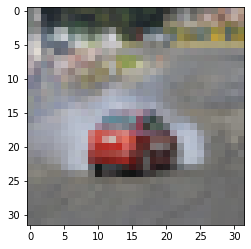

Label: 1


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1,2,0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Plot random sample of the data:

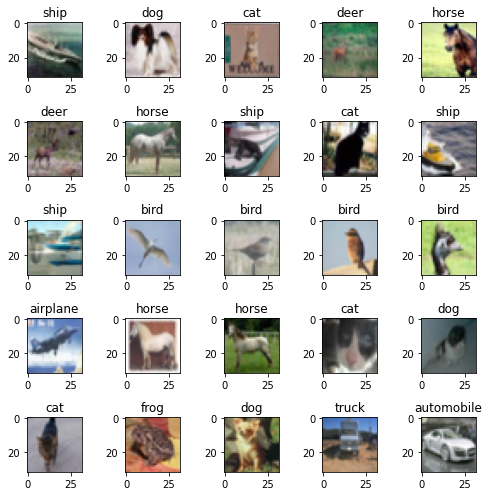

In [6]:
fig, axs = plt.subplots(5,5,figsize=(7,7))

for ax in axs.flatten():
    i = torch.randint(50000, (1,1)).item()
    ax.imshow(train_imgs[i])
    ax.set_title(labels_map[train_y[i].item()])
plt.tight_layout()

## Prepare the data

We create the training and validation data and labels.

The data is reshaped to a 4-dimensional tensor. dim 0 corresponds to list of images dim 1 is "depth" - so 3 layers for RGB; dim 2 and 3 are for the 32 pixels height and width of the images. 

We didvide pixel values by 256 so that PyTorch can work with floating point numbers in (0,1).

In [7]:
test_y.shape, test_imgs.shape, train_y.shape, train_imgs.shape

(torch.Size([10000]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([50000, 32, 32, 3]))

## Create a benchmark to judge neural net results against

Will an accuracy of above 10% imply that our neural net is doing better than chance and therefore doing a good job? Maybe.

To create a benchmark, we do a very simple prediction: we calculate the value of the "average" pixel for all the images in each category. Then for each image, we 

First create a benchmark to measure results of training neural net on.

We calculate the average RGB value for each pixel for each category. Then calculate the distance of an image form the average image for each category. Shortest distance is classified as that image. Can we do better than 10% accuracy??

In [8]:
avg_img = torch.zeros((10,32,32,3))
for i in np.arange(10):
    mask = train_y == i
    avg_img[i] = train_imgs[mask].mean(0)
    

Display our "average images". Kinda cool! The automobile and truck look like vehicles coming through the mist and the colours look different for different categories. There will be a lot of confusion between wild animals and cars/trucks for example, but the prediction based on distance from mean image should be quite good.

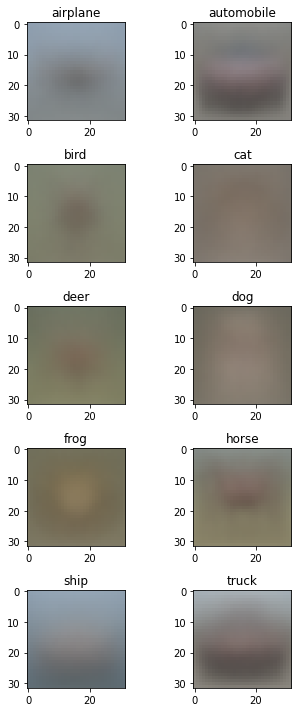

In [9]:
fig, axs = plt.subplots(5,2,figsize=(5,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_img[i])
    ax.set_title(labels_map[i])
plt.tight_layout()

Test our benchmark prediction. 28%!! Pretty good for just calculating an average. We now need our neural net to outperform 28% accuracy to be any good.

In [10]:
def cifar_distance(a,b): return ((a-b)**2).abs().mean((-1,-2,-3))
def predictions(a): return torch.argmin(a, dim=1)

preds = predictions(cifar_distance(test_imgs[:,None], avg_img[None]))
accuracy = (preds == test_y).sum()/test_imgs.shape[0]
accuracy

tensor(0.2774)

Just for curiousity, let's plot the confusion matrix. Some parts are as we expect from out crude method: it gets confused between deer and frogs (green backgrounds?) and birds and planes (sky?). 

Finally, there were 1000 of each category in the 10,000 test data set. However, our simple rule predicted either airplane or frog 4,500 times. So a lot of images look like the average frog or airplane!

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([2016,  657,  378,  211,  432, 1065, 2485,  622,  885, 1249]))

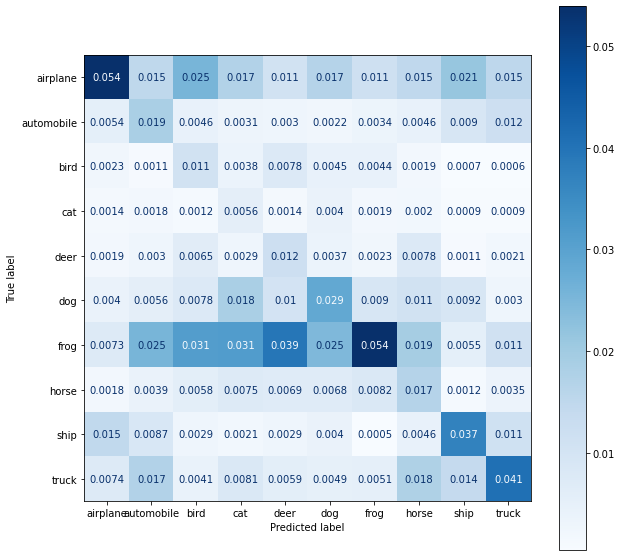

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display(torch.unique(preds, return_counts=True))

cm = confusion_matrix(preds, test_y,
                      normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes
                             )

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)

## Implement a neural network



In [42]:
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
device

device(type='cpu')

Prepare the data. To check code runs, I will do a tiny amount of training data.

We also flatten the image data to vectors so that we can feed into a basic NN.

In [45]:
num_epochs = 10
# num_classes = 2
batch_size = 100
learning_rate = 0.005

# I wasn't going to copy Cactus_classification, but defining 'criterion'
# gives good flexibility
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

In [48]:
transform = transforms.Compose([transforms.ToTensor(), #transforms.Resize(32),
                                # transforms.Lambda(lambda x: torch.flatten(x))
                               ])
target_transforms = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float)
                                     .scatter_(0, torch.tensor(y), value=1))

# Prepare 1000 sample training set
CIFAR_data_small = CIFAR10(data_folder, train=True, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_data_small.data = CIFAR_data_small.data[:10000]
CIFAR_data_small.targets = CIFAR_data_small.targets[:10000]

# Prepare 1000 sample test set (weird balance, but easy to test)
CIFAR_test_small = CIFAR10(data_folder, train=False, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_test_small.data = CIFAR_test_small.data[:2500]
CIFAR_test_small.targets = CIFAR_test_small.targets[:2500]

train_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

test_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

In [50]:
CIFAR_data_small.data.shape, type(CIFAR_data_small.data), CIFAR_test_small.data.shape

((10000, 32, 32, 3), numpy.ndarray, (2500, 32, 32, 3))

Check that we have one-hot encoded the labels data. Looks like we have!

In [51]:
train_features, train_labels = next(iter(test_small_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].permute(1,2,0)
label = train_labels[0]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100, 10])
Label: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [52]:
# Define model

# models should subclass nn.Module. Docs here:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # This flattens the 3 x 32 x 32 image matrices to vectors
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [53]:
# print("Model structure: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

## Training the model

In [59]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in test_small_dl:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_small_dl.sampler)
    valid_loss = valid_loss/len(test_small_dl.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # following is to check whether any parameters are being updated. 
    # They are not!
    for name, param in model.named_parameters():
        print('{} sum of parameters: {:.3f}'.format(name, param.sum().item()))

Epoch: 1 	Training Loss: 2.304881 	Validation Loss: 2.304881
linear_relu_stack.1.weight sum of parameters: -5.663
linear_relu_stack.1.bias sum of parameters: -0.361
linear_relu_stack.3.weight sum of parameters: -7.584
linear_relu_stack.3.bias sum of parameters: 0.911
linear_relu_stack.5.weight sum of parameters: -0.697
linear_relu_stack.5.bias sum of parameters: -0.071
Epoch: 2 	Training Loss: 2.304881 	Validation Loss: 2.304881
linear_relu_stack.1.weight sum of parameters: -5.663
linear_relu_stack.1.bias sum of parameters: -0.361
linear_relu_stack.3.weight sum of parameters: -7.584
linear_relu_stack.3.bias sum of parameters: 0.911
linear_relu_stack.5.weight sum of parameters: -0.697
linear_relu_stack.5.bias sum of parameters: -0.071
Epoch: 3 	Training Loss: 2.304881 	Validation Loss: 2.304881
linear_relu_stack.1.weight sum of parameters: -5.663
linear_relu_stack.1.bias sum of parameters: -0.361
linear_relu_stack.3.weight sum of parameters: -7.584
linear_relu_stack.3.bias sum of parame

## Test model on validation data

In [20]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_small_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.argmax(outputs.data)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

TypeError: iteration over a 0-d tensor